# Opioid Addiction Project
## Notebook 04: Modeling

This notebook executes the following tasks:

1. Model Preprocessing
2. Train a machine learning model
3. Score the model (measuring accuracy, precision, recall, F1, ROC)
4. Calibrate the model (and re-score, comparing uncalibrated vs. calibrated)
5. Save the model and calibration

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
import itertools

#Model Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn
import OpioidDataPrep as odp  #Custom functions for this project

#Modeling
from sklearn.linear_model import LogisticRegression
import xgboost #Tricky installation, see instructions (search for XGBoost)

#Model evaluation
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, 
                             classification_report, brier_score_loss, precision_score, 
                             recall_score, f1_score)

from sklearn.metrics import (brier_score_loss, )

#Calibration
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

#Visualization
import matplotlib.pyplot as plt

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 20
dataDir = './data/'

#Notebook Custom Parameters
useSMOTE = True

print('Pandas Version', pd.__version__)
print('XGBoost Version', xgboost.__version__)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Pandas Version 0.24.2
XGBoost Version 0.90


# 1. Load Data

This step loads the data from the file `features.pickle.zip`.

In [2]:
#Load Data
df = pd.read_pickle(dataDir+'features.pickle.zip')
df

,IRSEX,AGE2,BNGDRKMON,HVYDRKMON,TXYRRECVD2,TXEVRRCVD2,FUMJ18,FUMJ21,MISUSE,IRCIGRC__GT1LTET2,...,EDUHIGHCAT__GT1LTET2,EDUHIGHCAT__GT2LTET3,EDUHIGHCAT__GT3LTET4,EDUHIGHCAT__GT4LTET5,BOOKED__GT1LTET2,BOOKED__GT2LTET3,BOOKED__GT3LTET85,BOOKED__GT85LTET94,BOOKED__GT94LTET97,BOOKED__GT97LTET98
19,0,-1.188806,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
20,1,-0.730225,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
21,0,-0.607937,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
23,0,-0.944230,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
33,0,-0.730225,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
34,0,-0.883085,1,1,0,0,1,1,1,1,...,0,1,0,0,1,0,0,0,0,0
36,1,2.174124,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
46,1,-0.944230,0,0,0,0,1,1,1,0,...,1,0,0,0,1,0,0,0,0,0
50,0,0.462087,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
52,0,-1.188806,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


# 2. Model Preprocessing

In this section we'll ...

* Split the data into features (X) and the outcome variable, MISUSE (Y).
* Split the data into training, validation, and test sets.
* Oversample the data to address imbalance (optional, depending on modeling needs)

In [3]:
#We'll first sort the data by column name, necessary to prevent errors later
#Specfically, calibrating with the cv='prefit' option fails without this sort
df = odp.sortDFbyColName(df)
df

,ADDPREV__GT1LTET2,ADDPREV__GT2LTET85,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDPREV__GT97LTET98,ADDPREV__GT98LTET99,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,...,MJYRTOT__GT985LTET991,MJYRTOT__GT991LTET993,MJYRTOT__GT993LTET994,MJYRTOT__GT994LTET997,MJYRTOT__GT997LTET998,PIPEVER__GT1LTET2,PIPEVER__GT2LTET94,PIPEVER__GT94LTET97,TXEVRRCVD2,TXYRRECVD2
19,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
21,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
23,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
33,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
34,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
46,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
50,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
52,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


## 2.1 Split Features (X) and Outcome (Y)

In [4]:
#Split X and Y
xCols = df.columns.difference(['MISUSE'])
dfX = df[xCols]
dfY = df.drop(xCols, axis=1)

#Inspect
print(dfX.head())
print(dfY.head(10))

    ADDPREV__GT1LTET2  ADDPREV__GT2LTET85  ADDPREV__GT85LTET94  \
19                  0                   0                    0   
20                  0                   0                    0   
21                  1                   0                    0   
23                  1                   0                    0   
33                  1                   0                    0   

    ADDPREV__GT94LTET97  ADDPREV__GT97LTET98  ADDPREV__GT98LTET99  \
19                    0                    0                    1   
20                    0                    0                    0   
21                    0                    0                    0   
23                    0                    0                    0   
33                    0                    0                    0   

    ADDSCEV__GT1LTET2  ADDSCEV__GT2LTET94  ADDSCEV__GT94LTET97  \
19                  0                   0                    0   
20                  0                   0               

## 2.2 Split into Training, Validation, and Test

In [5]:
#Train, Val, Test splits
trainPct = 0.6
valPct = 0.25
testPct = 0.15

#Splitsville!
trainX, valtestX, trainY, valtestY = train_test_split(
    dfX, dfY, train_size=(trainPct), shuffle=True)
valX, testX, valY, testY = train_test_split(
     valtestX, valtestY, train_size=(valPct/(valPct+testPct)), shuffle=True)

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(32014, 102)
(32014, 1)
(13340, 102)
(13340, 1)
(8004, 102)
(8004, 1)


In [6]:
#SMOTE Oversampling
if useSMOTE:
    #From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
    os = SMOTE(random_state=0)
    columns = trainX.columns
    osX, osY = os.fit_sample(trainX, trainY)
    osX = pd.DataFrame(data=osX,columns=columns)
    osY = pd.DataFrame(data=osY,columns=['MISUSE'])

    #Check the numbers of our data
    print("length of oversampled data is ",len(osX))
    print("Number MISUSE==0",len(osY[osY['MISUSE']==0]))
    print("Number MISUSE==1",len(osY[osY['MISUSE']==1]))
    print("Proportion of MISUSE==0 in oversampled data is ",len(osY[osY['MISUSE']==0])/len(osX))
    print("Proportion of MISUSE==1 in oversampled data is ",len(osY[osY['MISUSE']==1])/len(osX))

    #Check Shapes
    print(trainX.shape)
    print(trainY.shape)
    print(osX.shape)
    print(osY.shape)
    print(valX.shape)
    print(valY.shape)
    print(testX.shape)
    print(testY.shape)

    #Finally, set trainX and trainY to be osX and osY 
    #(allows the model to use trainX and trainY regardless of whether oversampling is selected)
    trainX, trainY = osX, osY

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  53608
Number MISUSE==0 26804
Number MISUSE==1 26804
Proportion of MISUSE==0 in oversampled data is  0.5
Proportion of MISUSE==1 in oversampled data is  0.5
(32014, 102)
(32014, 1)
(53608, 102)
(53608, 1)
(13340, 102)
(13340, 1)
(8004, 102)
(8004, 1)


In [7]:
#Save data files necessary for calculating feature importance, before conversion to numpy arrays
valX.to_pickle(dataDir+'valX.pickle.zip')
testX.to_pickle(dataDir+'testX.pickle.zip')
'''Note, the .to_pickle command INFERS zip compression based on the '.zip'
extension. Changing the extension will result in a HUGE file instead of a 
compressed file.
''';

In [8]:
#Finally we'll convert these to numpy arrays to help with xgboost and calibration
valX = valX[trainX.columns]
testX = testX[trainX.columns]

# 3. Model Training

In this section we'll train a model.

## 3.1 Logistic Regression

Train a logistic regression model

In [9]:
#Set and train a logistic regression model
modelLR = LogisticRegression()
modelLR.fit(trainX, trainY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## 3.2 Extreme Gradient Boosting (XGBoost)

Train an XGBoost model.

In [10]:
#Set and train the XGB model
modelXGB = xgboost.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=20, n_jobs=-1,
                                booster='gbtree'
                                )
'''Notes:
    1. n_jobs=-1 maximizes CPU utilization
    2. Beware running high max_depth and n_estimators; the shapley estimator in notebook 5
    crashes with high values.'''
modelXGB.fit(trainX, trainY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# 4. Model Evaluation (uncalibrated)

Here we'll develop the scoring routines to evaluate the uncalibrated model. We'll re-score in the calibration section to compare the uncalibrated vs. calibrated models.

## 4.1 Simple Counts

We'll begin by calculating simple counts of the model's predictions

In [11]:
#Count predictions. This gives a rough idea of the number of predictions
def predCounts(predsIn):
    '''Simple function to count our predictions
    NOTES:
    Return format: [[prediction1, count of prediction1]
                    [prediction2, count of prediction2]]

    The .T at the end simply transposes the array.

    What's nice about this function is it will also detect any counts
    that aren't 0 or 1, which can occasionally happen.
    '''
    return np.asarray(np.unique(predsIn, return_counts=True)).T

preds = modelXGB.predict(valX)
predCountFreq = predCounts(preds)
#print(predCountFreq) #Commenting out here because it's printed below

## 4.2 Confusion Matrix

In [12]:
#Helper Functions for Summarizing and Plotting Results
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Documented here as it is in the source.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized Confusion Matrix") #Commenting out since we plot this in a graph
    else:
        pass
        #print('Confusion Matrix') #Commenting out since we plot this in a graph

    #print(cm) #Commenting out since we plot this in a graph

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

In [13]:
#Create text classification report
#print(classification_report(valY, preds)) #Commenting out here because it's printed below

# Compute confusion matrix
cnf_matrix = confusion_matrix(valY, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0, 1]

## 4.3 ROC Curve

In [14]:
#Function to plot ROC Curve
def pltROCCurve(fprIn, tprIn, trueY, predProbs):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fprIn, tprIn, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_true=trueY, y_score=predProbs))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate\n(how often predicts misuse when no misuse)')
    plt.ylabel('True Positive Rate\n(how often predicts misuse when actual misuse)')
    plt.show()

In [15]:
#fpr, tpr, thresholds = roc_curve(valY, predProbs)

## 4.4 Calibraiton Curve

In [16]:
#Function to plot calibration curve
def pltCalCurve(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, 
                                             n_bins=20, strategy='quantile', normalize=True)

    #Plot diag line
    plt.plot([0, 1], [0, 1], linestyle='--')

    #Plot calibration curves
    plt.plot(prob_pred, prob_true, marker='.')
    plt.xlabel('Predicted Probabilities')
    plt.ylabel('Actual Probabilities')
    plt.show()

## 4.5 Metrics Summary

This is just a convenient place to put all the metrics we've already calculated in one spot.

In [17]:
def resultsSummary(preds, predProbs, trueY):
    #Calculate Inputs
    cnf_matrix = confusion_matrix(trueY, preds)

    #Counts
    print('PREDICTION COUNTS:\n', predCounts(preds))

    #Accuracy
    print('\nACCURACY SCORES:')
    print('Model Accuracy: {:.2%}'.format(accuracy_score(y_true=trueY, y_pred=preds, normalize=True)))
    print('Model ROC AUC:  {:.2%}'.format(roc_auc_score(y_true=trueY, y_score=predProbs)))
    print('Brier Score Loss:  {:.3}'.format(brier_score_loss(y_true=trueY, y_prob=predProbs)))
    print('  (Brier Score Loss evaluates probability estimates, lower is better)')

    #Descriptive Stats
    print('\nDESCRIPTIVE STATS ON PREDICTED PROBABILITIES:')
    print(pd.DataFrame({'Descriptive Stats':predProbs}).describe())
    
    #Distribution of Predictions
    print('\nDISTRIBUTION OF PREDICTED PROBABILITIES:')
    plt.hist(predProbs, bins=50)
    plt.show()

    #Classificaiton Report
    print('\nCLASSIFICATION REPORT:')
    print(classification_report(trueY, preds))

    #Plot Confusion Matrix
    print('CONFUSION MATRIX:')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    #Print ROC Curve
    fpr, tpr, thresholds = roc_curve(trueY, predProbs)
    print('ROC CURVE:')
    pltROCCurve(fpr, tpr, trueY, predProbs)
    
    #Plot CalCurve
    pltCalCurve(trueY, predProbs)

PREDICTION COUNTS:
 [[   0 9122]
 [   1 4218]]

ACCURACY SCORES:
Model Accuracy: 73.76%
Model ROC AUC:  77.24%
Brier Score Loss:  0.189
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.421653
std             0.219904
min             0.011997
25%             0.252122
50%             0.366314
75%             0.566763
max             0.981282

DISTRIBUTION OF PREDICTED PROBABILITIES:


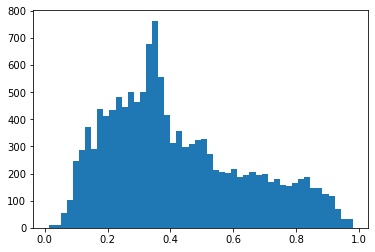


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     11163
           1       0.34      0.66      0.45      2177

    accuracy                           0.74     13340
   macro avg       0.63      0.71      0.64     13340
weighted avg       0.83      0.74      0.77     13340

CONFUSION MATRIX:


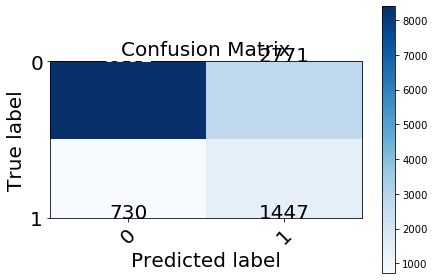

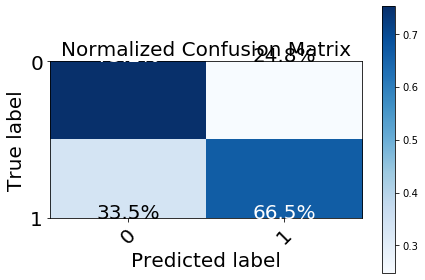

ROC CURVE:


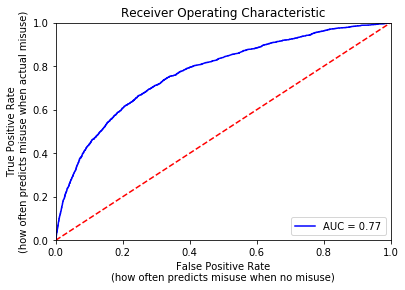

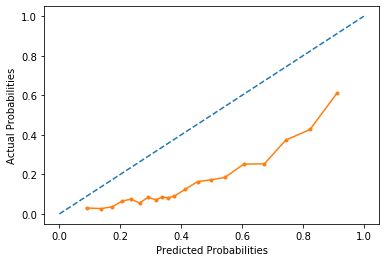

In [18]:
#Generate LR Predictions
predsLR = modelLR.predict(valX)
predProbsLR = modelLR.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelLRPredProbs.npy', arr=predProbsLR)

#Summarize
resultsSummary(predsLR, predProbsLR, valY)

PREDICTION COUNTS:
 [[    0 11561]
 [    1  1779]]

ACCURACY SCORES:
Model Accuracy: 82.80%
Model ROC AUC:  74.58%
Brier Score Loss:  0.137
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.298779
std             0.166262
min             0.076963
25%             0.172434
50%             0.254716
75%             0.355744
max             0.863043

DISTRIBUTION OF PREDICTED PROBABILITIES:


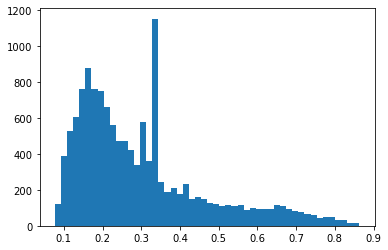


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     11163
           1       0.47      0.38      0.42      2177

    accuracy                           0.83     13340
   macro avg       0.68      0.65      0.66     13340
weighted avg       0.82      0.83      0.82     13340

CONFUSION MATRIX:


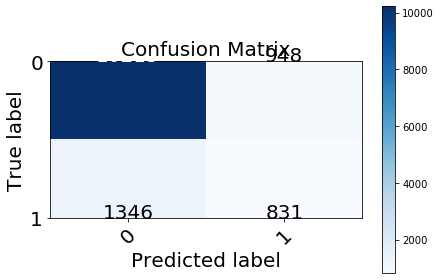

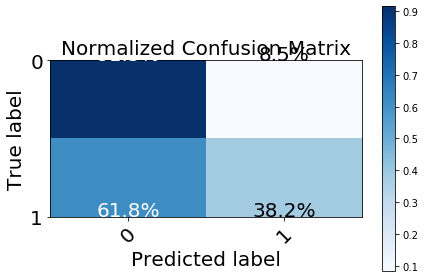

ROC CURVE:


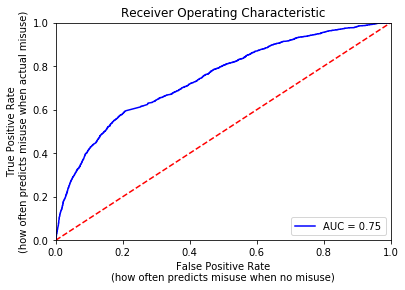

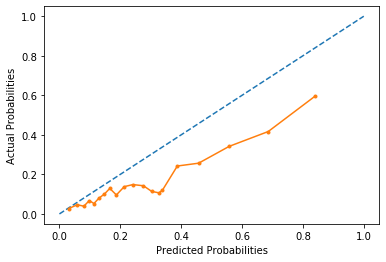

In [19]:
#Generate XGB Predictions
predsXGB = modelXGB.predict(valX)
predProbsXGB = modelXGB.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelXGBPredProbs.npy', arr=predProbsXGB)

#Summarize
resultsSummary(predsXGB, predProbsXGB, valY)

# 5. Calibration

This section seeks to calibrate the model. That is, it makes the acutal probabilities from the model align with the actual probabilities.

Note, we calibrate on the validation data (valX, valY), and then evaluate with `resultsSummary` on the test data (testY)

In [20]:
#Now we'll try to calibrate the model
runCalibration = True

## 5.1 Calibrate Logistic Regression Model

In [21]:
if runCalibration:
    calibratorLR = CalibratedClassifierCV(modelLR, cv=10, method='isotonic')
    calibratorLR.fit(valX, valY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\linear

PREDICTION COUNTS:
 [[   0 7621]
 [   1  383]]

ACCURACY SCORES:
Model Accuracy: 85.02%
Model ROC AUC:  76.59%
Brier Score Loss:  0.113
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.163453
std             0.156454
min             0.000000
25%             0.063206
50%             0.100541
75%             0.210264
max             0.896958

DISTRIBUTION OF PREDICTED PROBABILITIES:


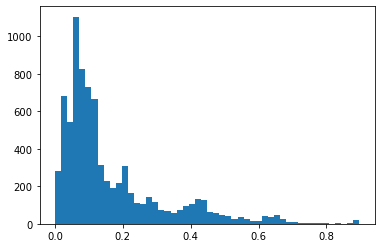


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6708
           1       0.63      0.19      0.29      1296

    accuracy                           0.85      8004
   macro avg       0.74      0.58      0.60      8004
weighted avg       0.82      0.85      0.81      8004

CONFUSION MATRIX:


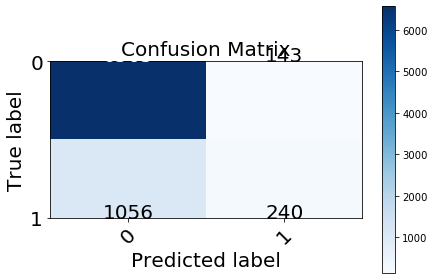

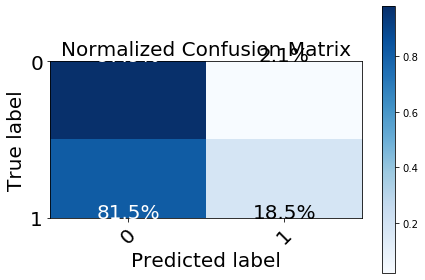

ROC CURVE:


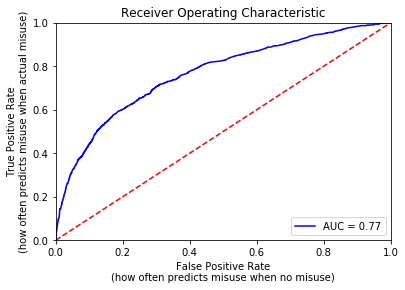

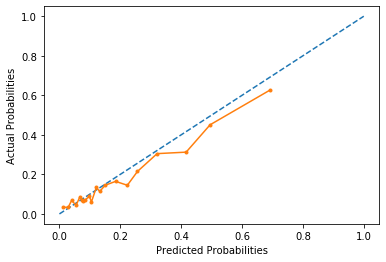

In [22]:
#Now recalculate predictions and print results
if runCalibration:
    predsLRCal = calibratorLR.predict(testX)
    predProbsLRCal = calibratorLR.predict_proba(testX)[:,1]
    resultsSummary(predsLRCal, predProbsLRCal, testY)

## 5.2 Calibrate XGBoost Model

In [24]:
if runCalibration:
    calibratorXGB = CalibratedClassifierCV(modelXGB, method='sigmoid', cv=10)
    #CK YOU LEFT OFF ON THE LINE ABOVE. 2 THINGS:
    #1. cv='prefit' I THINK CAN BE FIXED WITH RE-SORTING THE DATA. MIGHT WANT TO MAKE A MODULE FOR THIS, OR ADD
    #A DEF TO PREPROCESSING FILE. INCREASING TO cv=10 (FROM 3) GAVE A HUGE IMPROVEMENT.
    
    calibratorXGB.fit(valX, valY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7654]
 [   1  350]]

ACCURACY SCORES:
Model Accuracy: 84.71%
Model ROC AUC:  75.92%
Brier Score Loss:  0.115
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.163108
std             0.131871
min             0.071597
25%             0.088269
50%             0.107404
75%             0.170674
max             0.851022

DISTRIBUTION OF PREDICTED PROBABILITIES:


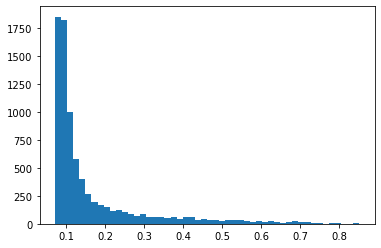


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      6708
           1       0.60      0.16      0.26      1296

    accuracy                           0.85      8004
   macro avg       0.73      0.57      0.59      8004
weighted avg       0.82      0.85      0.81      8004

CONFUSION MATRIX:


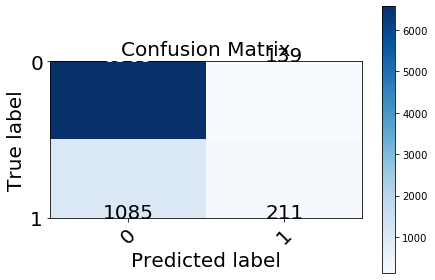

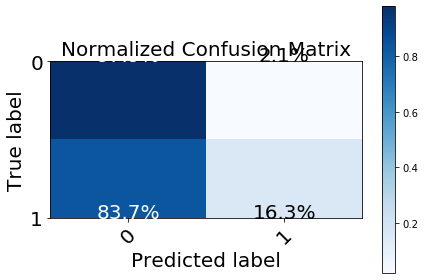

ROC CURVE:


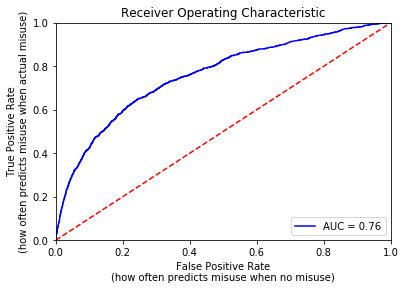

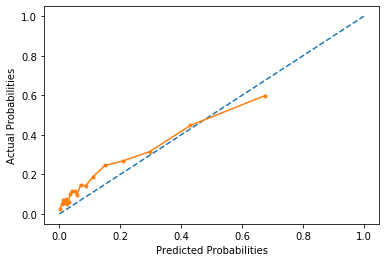

In [25]:
#Now recalculate predictions and print results
if runCalibration:
    predsXGBCal = calibratorXGB.predict(testX)
    predProbsXGBCal = calibratorXGB.predict_proba(testX)[:,1]
    resultsSummary(predsXGBCal, predProbsXGBCal, testY)

# 6. Side By Side Model Comparisons

Here we'll look to compare results across all our models.

## 6.1 Side By Side Calibration Curves

Note these won't necessarily match the calibration curves ploted above because the ones in this section are calcualted on the test data, not the validation data. This strategy is correct because the calibrations themselves are generated from the validation data.

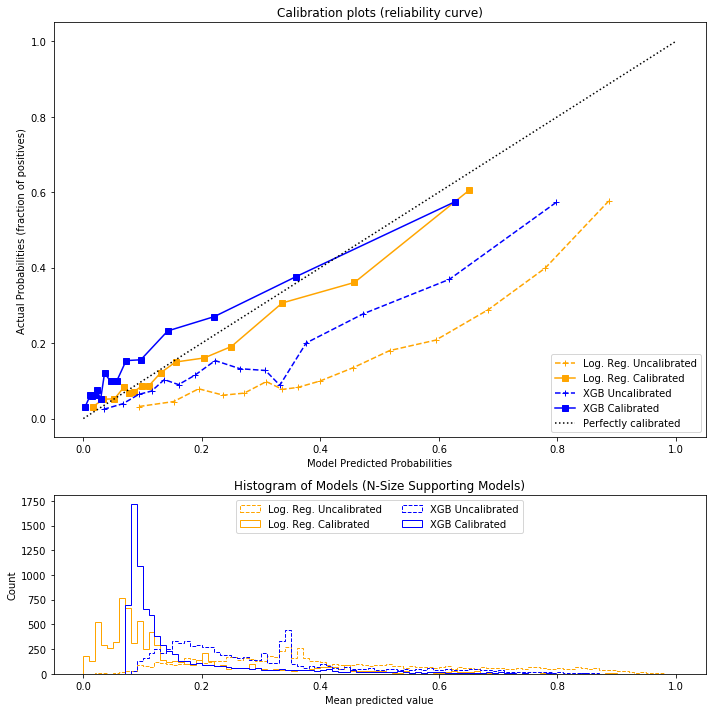

,Model,Brier Loss,ROC AUC,Precision,Recall,F1,Accuracy
0,Log. Reg. Uncalibrated,0.189973,0.764833,0.335689,0.659722,0.444965,0.733508
0,Log. Reg. Calibrated,0.113024,0.765919,0.626632,0.185185,0.285884,0.850200
0,XGB Uncalibrated,0.136426,0.745401,0.468026,0.389660,0.425263,0.829460
0,XGB Calibrated,0.115432,0.759213,0.602857,0.162809,0.256379,0.847076


In [26]:
#Initiate evaluation summary dataframe
dfEval = pd.DataFrame({'Model':[], 'Brier Loss':[], 'ROC AUC':[], 'Precision':[], 'Recall':[], 'F1':[], 'Accuracy':[]})

#Set up plots
fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

#Iterate through each model: print it scores and plot its calibration curve
for clf, name, lineColor, lineStyle in \
    [(modelLR, 'Log. Reg. Uncalibrated', 'orange', '+--'),
     (calibratorLR,'Log. Reg. Calibrated', 'orange', 's-'),
     (modelXGB, 'XGB Uncalibrated', 'blue', '+--'),     
     (calibratorXGB,'XGB Calibrated', 'blue', 's-'),
    ]:

    #Generate predictions
    preds = clf.predict(testX)
    predProbs = clf.predict_proba(testX)[:, 1]
    
    #Generate calibration curve data
    prob_true, prob_pred = calibration_curve(y_true=testY, y_prob=predProbs, 
                                             n_bins=15, strategy='quantile', normalize=True)

    #Plot calibration curve
    ax1.plot(prob_pred, prob_true, lineStyle, color=lineColor, label=name)
    
    #Plot histogram of probabilities (support)
    ax2.hist(predProbs, range=(0, 1), bins=100, label=name, color=lineColor, 
             linestyle=lineStyle[1:], histtype="step", lw=1)

    #Populate evaulation dataframe
    dfEval = pd.concat([dfEval, pd.DataFrame({'Model':[name],
                                          'Brier Loss':[brier_score_loss(y_true=testY, y_prob=predProbs)], 
                                          'ROC AUC':[roc_auc_score(y_true=testY, y_score=predProbs)], 
                                          'Precision':[precision_score(y_true=testY, y_pred=preds)], 
                                          'Recall':[recall_score(y_true=testY, y_pred=preds)], 
                                          'F1':[f1_score(y_true=testY, y_pred=preds)], 
                                          'Accuracy':[accuracy_score(y_true=testY, y_pred=preds)]
                                         })])


#Stuff universal to all plots
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.set_xlabel("Model Predicted Probabilities")
ax1.set_ylabel("Actual Probabilities (fraction of positives)")
ax1.set_ylim([-0.05, 1.05])

ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax2.set_title('Histogram of Models (N-Size Supporting Models)')

zoomIn=False
if zoomIn:
    ax1.set_ylim([-0.00, 0.20])
    ax1.set_xlim([-0.00, 0.20])
    ax2.set_xlim([-0.00, 0.20])

plt.tight_layout()

plt.show() #Show plot
dfEval #Show eval

# 7. Save Model to Disk

Saving the model to disk at this point saves time, specifically so we don't have to re-train it every time we want to use it for predictions, feature importance, report generation, etc.

In [27]:
#Save model and any other necessary files
joblib.dump(modelLR, dataDir+'modelLR.model')
joblib.dump(modelXGB, dataDir+'modelXGB.model')

if runCalibration:
    joblib.dump(calibratorLR, dataDir+'calibLR.model')
    joblib.dump(calibratorXGB, dataDir+'calibXGB.model')

